In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio
import cv2

In [2]:
data = pd.concat([
    pd.read_pickle("data.2d.pkl"),
#     pd.read_pickle("data.pure.dirty_canny.pkl"),
    pd.read_pickle("data.pure.original.pkl"),
#     pd.read_pickle("data.pure.initial.pkl"),
#     pd.read_pickle("data.pure.dirty_canny_simple.pkl"),
#     pd.read_pickle("data.pure.dirty_canny.contrast_fix.pkl"),
#     pd.read_pickle("data.pure.dirty_canny.contrast_fix_extreme.pkl"),
#     pd.read_pickle("data.pure.dirty_canny.contrast_fix_extreme.bias_bounds.pkl"),
#     pd.read_pickle("data.pure.dirty_canny.contrast_fix_extreme.selection_tweeks.pkl"),
#     pd.read_pickle("data.pure.adjusted1.pkl"),
#     pd.read_pickle("data.pure.adjusted1.fixcombine.pkl"),
#     pd.read_pickle("data.pure.adjusted1.fixcombine2.bias.fixfinal.pkl"),
#     pd.read_pickle("data.pure.adjusted2.orig_canny.pkl"),
    pd.read_pickle("data.pure.adjusted2.iterative_canny_a5.pkl"),
    pd.read_pickle("data.pure.adjusted2.special_canny.pkl"),
])
data.head()
data["subject"] = data["subject"].astype(int)
data["video"] = data["video"].astype(int)
data["error"] = np.sqrt((data["center_x"] - data["target_x"])**2 + (data["center_y"] - data["target_y"])**2)

In [3]:
methods = set(data["method"])
def method_iterator(data):
    for m in methods:
        yield m, data[data["method"] == m]

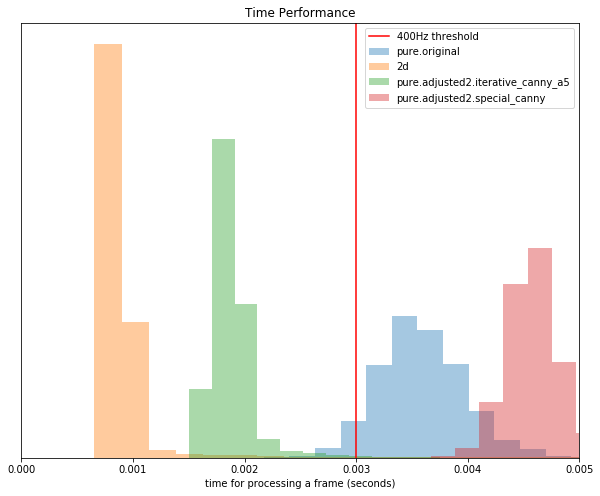

In [4]:
plt.figure(figsize=(10, 8))
plt.title("Time Performance")
for m, d in method_iterator(data):
    sns.distplot(d["time"], label=m, kde=False)
plt.xlim(0, 0.005)
plt.xlabel("time for processing a frame (seconds)")
plt.yticks([],[])
plt.axvline(x=0.003, color='r', label="400Hz threshold")
plt.legend()

In [5]:
# plt.figure(figsize=(8, 8))
# max_err = 30
# plt.title(f"Error vs. Confidence (for Error < {max_err})")
# sns.scatterplot(data=data[data["error"] < max_err], x="confidence", y="error", hue="method", alpha=0.1)

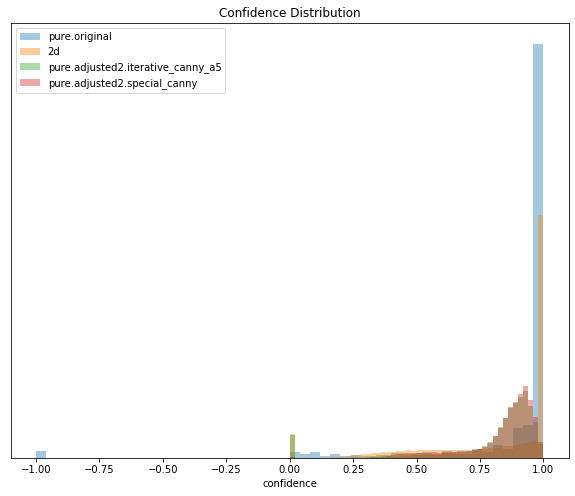

In [6]:
plt.figure(figsize=(10, 8))
plt.title("Confidence Distribution")
for m, d in method_iterator(data):
    sns.distplot(d["confidence"], label=m, kde=False)
plt.yticks([], [])
plt.legend()

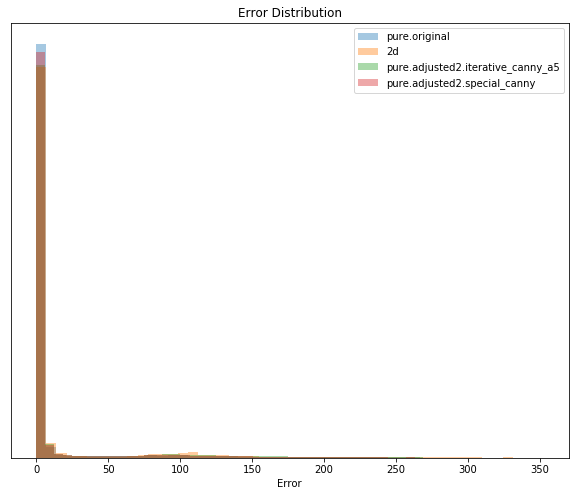

In [7]:
plt.figure(figsize=(10, 8))
plt.title("Error Distribution")
for m, d in method_iterator(data):
    sns.distplot(d["error"], label=m, kde=False)
plt.xlabel("Error")
plt.yticks([], [])
plt.legend()

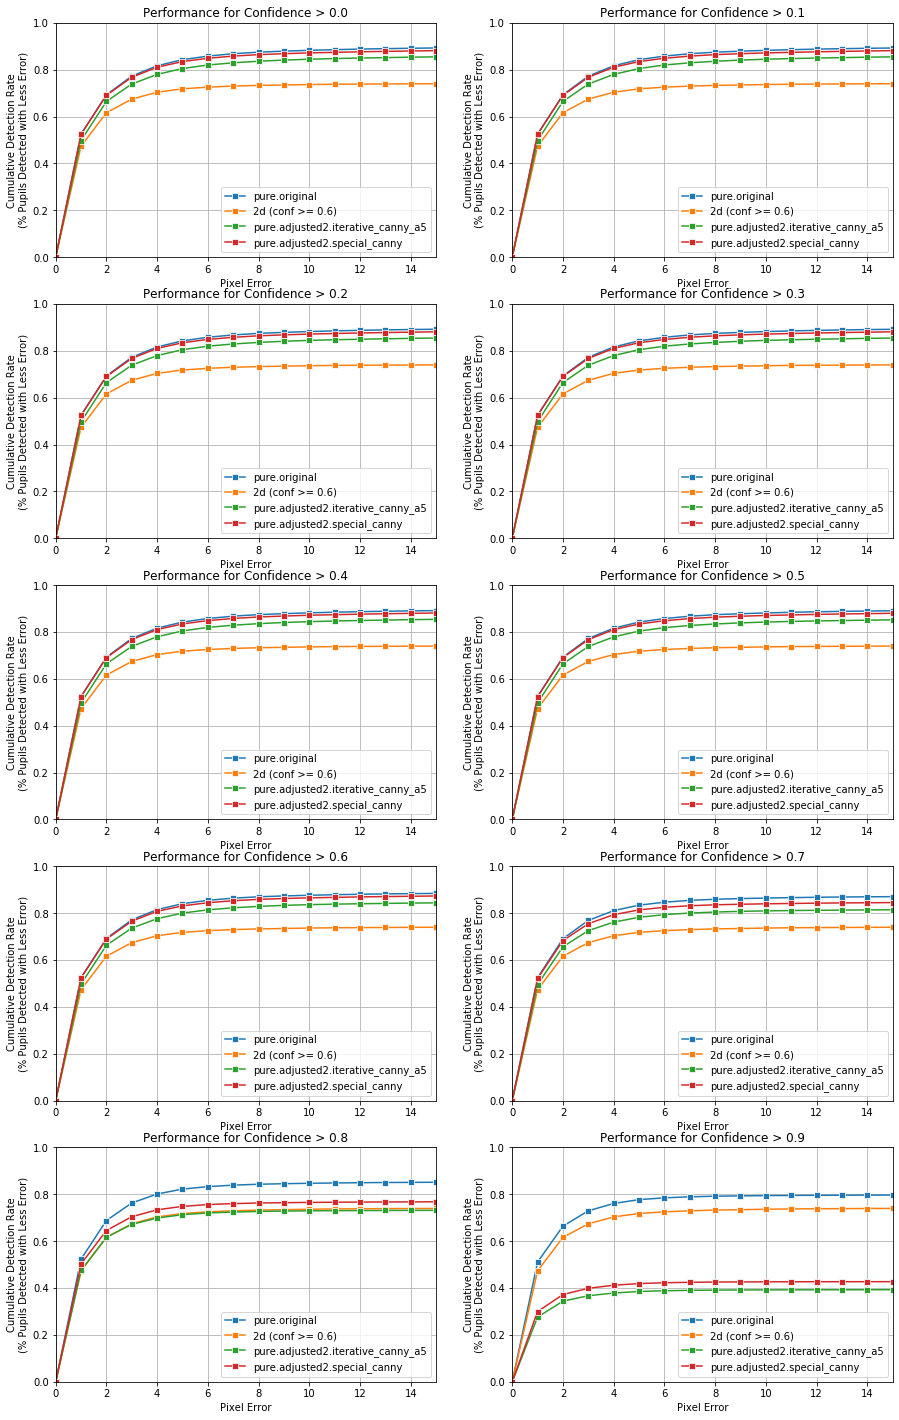

In [8]:
max_err = 16
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
axes = axes.reshape(-1)
for i, conf in enumerate(np.arange(0, 1, 0.1)):
    plt.sca(axes[i])
    plt.title(f"Performance for Confidence > {conf:.1f}")
    
    for m, d in method_iterator(data):
        c = conf if m != "2d" else 0.6
        label = m if m != "2d" else "2d (conf >= 0.6)"
        errors = d.loc[d["confidence"] >= c,"error"]
        errors_cum = errors.groupby(pd.cut(errors, bins=range(-1, max_err))).count().cumsum() / len(d)
        errors_cum = errors_cum.rename(columns=str).reset_index()[0]
        sns.lineplot(data=errors_cum, label=label, marker="s")
        
    plt.xlabel("Pixel Error")
    plt.ylabel("Cumulative Detection Rate\n(% Pupils Detected with Less Error)")
    plt.xlim(0, max_err-1)
    plt.ylim(0, 1)
    plt.grid()

In [9]:
data["key"] = data["subject"].astype(str) + "-" + data["video"].astype(str) + "-" + data["frame"].astype(str)

In [10]:
compare_to = "pure.adjusted2.iterative_canny"
def error_diff(group):
    error_orig = group.loc[group["method"] == "pure.original", "error"]
    error_reimpl = group.loc[group["method"] == compare_to, "error"]
    return error_orig - error_reimpl
# NOTE: Apply takes a lot of time, so we filter relevant rows/cols before.
tmp = data[data["confidence"] > 0]
tmp = tmp.loc[tmp["method"].isin(("pure.original", compare_to)), ["key", "error", "method"]]
error_diffs = tmp.groupby("key").apply(error_diff).droplevel(1)

In [11]:
lookup = data.set_index(["subject", "video", "frame", "method"])
n = 0
for key, error in error_diffs.sort_values().iteritems():
    subject, video, frame = (int(v) for v in key.split("-"))
    if (
        lookup.loc[(subject, video, frame, "pure.original"), "confidence"] < 0.5
        and lookup.loc[(subject, video, frame, compare_to), "confidence"] < 0.5
    ):
        print("skipping", subject, video, frame)
        continue
    else:
        n += 1
    if n > 100:
        break
    img = imageio.imread(f"../LPW/images/{subject}/{video}/{frame:04}.png")
    r1 = lookup.loc[subject, video, frame, "pure.original"]
    r2 = lookup.loc[subject, video, frame, compare_to]
    cv2.ellipse(
        img,
        tuple(int(v*2) for v in r1[["center_x", "center_y"]]),
        tuple(int(v) for v in r1[["first_ax", "second_ax"]]),
        r1["angle"],
        0, 360,
        (255, 0, 0),
        2
    )
    cv2.ellipse(
        img,
        tuple(int(v*2) for v in r2[["center_x", "center_y"]]),
        tuple(int(v) for v in r2[["first_ax", "second_ax"]]),
        r2["angle"],
        0, 360,
        (0, 255, 0),
        2
    )
    plt.figure(figsize=(3,3))
    plt.title(f"{error}\n{subject}-{video}-{frame}")
    plt.imshow(img)

TypeError: cannot do label indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [1] of <class 'int'>